# Vacancy formation energy

Using the iron GAP, calcualte the vacancy formation energy in a 3x3x3 supercell.

In [1]:
from __future__ import print_function

# stdlib
import os

# non-stdlib
import ase
import numpy as np
from ase.build import bulk
from ase.constraints import UnitCellFilter
from ase.optimize import LBFGS
# Use quippy for GAP iron model
from quippy import Potential

In [2]:
%matplotlib inline

In [3]:
# primitive cell and bulk with a vacancy
lattice_constant = 2.84

prim = bulk('Fe', a=lattice_constant)
vacancy = (bulk('Fe', a=lattice_constant, cubic=True) * (3, 3, 3))[:-1]

In [4]:
# Initialise the GAP
cwd = os.getcwd()

try:
    os.chdir('/opt/share/potentials/GAP/Iron/gp33b/')
    fe_gap = Potential("IP GAP", param_filename='gp33b.xml')
finally:
    os.chdir(cwd)

In [5]:
# Use primitive cell as the zero energy
prim.set_calculator(fe_gap)

ucf = UnitCellFilter(prim)
opt = LBFGS(ucf)
opt.run(fmax=0.0001)

e_prim = prim.get_potential_energy()
v_prim = prim.get_volume()

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 07:10:53    -3460.933167*       0.0830
LBFGS:    1 07:10:54    -3460.933375*       0.0340
LBFGS:    2 07:10:54    -3460.933417*       0.0002
LBFGS:    3 07:10:54    -3460.933417*       0.0000


In [6]:
# Optimise positions at each volume point
vacancy.set_calculator(fe_gap)

volumes = []
energies = []

for cell_a in np.linspace(vacancy.cell[0][0]*0.98, vacancy.cell[0][0]*1.02, 7):
    vacancy.set_cell((cell_a, cell_a, cell_a), scale_atoms=True)
    opt = LBFGS(vacancy)
    opt.run(fmax=0.001)
    volumes.append(vacancy.get_volume())
    energies.append(vacancy.get_potential_energy())

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 07:10:54  -183426.138911*       0.7013
LBFGS:    1 07:10:55  -183426.191800*       0.5911
LBFGS:    2 07:10:55  -183426.316606*       0.1703
LBFGS:    3 07:10:55  -183426.335180*       0.1541
LBFGS:    4 07:10:55  -183426.340808*       0.1225
LBFGS:    5 07:10:55  -183426.347474*       0.0366
LBFGS:    6 07:10:55  -183426.348136*       0.0114
LBFGS:    7 07:10:56  -183426.348186*       0.0035
LBFGS:    8 07:10:56  -183426.348191*       0.0028
LBFGS:    9 07:10:56  -183426.348197*       0.0016
LBFGS:   10 07:10:56  -183426.348199*       0.0012
LBFGS:   11 07:10:56  -183426.348199*       0.0007
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 07:10:56  -183426.911230*       0.0440
LBFGS:    1 07:10:56  -183426.911455*       0.0346
LBFGS:    2 07:10:57  -183426.911856*       0.0102
LBFGS:    3 07:10:57  -183426.911876*

Bulk modulus:                172.598 GPa
Vacancy formation energy:      2.266 eV
Vacancy volume:                8.383 A³


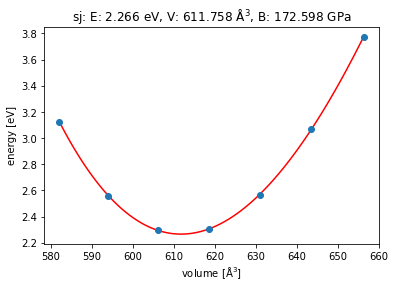

In [7]:
from ase.eos import EquationOfState
eos = EquationOfState(volumes, [e - len(vacancy) * e_prim for e in energies])
from ase.units import GPa

v0, e0, B = eos.fit()
print('Bulk modulus:              {:9.3f} GPa'.format(B / GPa))
print('Vacancy formation energy:  {:9.3f} eV'.format(e0))
print('Vacancy volume:            {:9.3f} A³'.format(v0 - 53*v_prim))
eos.plot()